# Testing assumptions about data shape and model choice

## Things we want to test

1. Are classifiers or regressors more accurate?
    * Regressors are more convenient due to margin-picking tie-breaker


2. Does it make a difference organising data by match (each match = 1 row) or team match (each match = 2 rows, 1 per participating team)?
    * Team match is more convenient for calculating secondary features and reduces number of columns while doubling number of rows, which can help with Curse of Dimensionality, but splits the key observation (the match) into two that have to be combined later.


3. Which metric is better for model evaluation?
    * [Matter of Stats](http://www.matterofstats.com/mafl-stats-journal/2018/5/17/accuracy-versus-mae-for-assessing-forecaster-ability-in-a-finite-season) suggests that evaluating on, and optimising to, mean absolute error is better than accuracy (perhaps using log loss instead of accuracy for a classifier?), because it is more consistent in identifying the best model.

In [1]:
# Python modules
import dateutil
from datetime import datetime
import re

# Data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit Learn utility classes & functions
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Scikit Learn models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Our own code
from src.data.preprocessing import betting_model_df, team_betting_model_df
from src.model.metrics import measure_estimators

np.random.seed(42)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
model_df = betting_model_df()
model_df

,home_team,away_team,home_score,away_score,home_win_odds,home_line_odds,away_win_odds,away_line_odds,round_number,year
0,Richmond,Carlton,64.0,120.0,2.89,16.5,1.42,-16.5,1,2010
1,Geelong,Essendon,125.0,94.0,1.21,-28.5,4.50,28.5,1,2010
2,Sydney,St Kilda,88.0,96.0,2.64,14.5,1.49,-14.5,1,2010
3,Brisbane,West Coast,114.0,82.0,1.32,-21.5,3.42,21.5,1,2010
4,Melbourne,Hawthorn,61.0,117.0,4.95,31.5,1.18,-31.5,1,2010
5,Port Adelaide,North Melbourne,96.0,82.0,1.42,-16.5,2.89,16.5,1,2010
6,Fremantle,Adelaide,118.0,62.0,1.96,1.5,1.85,-1.5,1,2010
7,Western Bulldogs,Collingwood,93.0,129.0,1.62,-8.5,2.31,8.5,1,2010
8,Brisbane,Carlton,107.0,88.0,1.34,-19.5,3.30,19.5,2,2010
9,West Coast,Port Adelaide,86.0,89.0,1.63,-10.5,2.30,10.5,2,2010


## Which is better for our task, classifiers or regressors?

In [3]:
model_features = pd.get_dummies(model_df.drop(['home_score', 'away_score'], axis=1))
model_labels = pd.DataFrame({'home_win': (model_df['home_score'] >= model_df['away_score']).astype(int),
                             'home_score_diff': model_df['home_score'] - model_df['away_score']})
X_train, X_test, y_train, y_test = train_test_split(model_features, model_labels)

In [4]:
# First we try some basic classifiers

# Just using basic, mostly linear, models to validate some ideas around how to shape the data & optimise.
# Throwing in RandomForest to get a data point for ensemble models.
classifiers = (LogisticRegression(),
              RidgeClassifier(),
              DecisionTreeClassifier(),
              LinearSVC(),
              KNeighborsClassifier(),
              RandomForestClassifier())
data = (X_train, X_test, y_train['home_win'], y_test['home_win'])

classifier_scores = measure_estimators(classifiers, data, model_type='classification')



LogisticRegression
Mean CV accuracy: 0.6864397838939806
Test accuracy: 0.7146892655367232

Mean CV negative error score: -0.57188686631313
Test error score: 9.85438304568618


RidgeClassifier
Mean CV accuracy: 0.698717473999561
Test accuracy: 0.7090395480225988

Mean CV negative error score: NA
Test error score: NA


DecisionTreeClassifier
Mean CV accuracy: 0.6214600128716501
Test accuracy: 0.6638418079096046

Mean CV negative error score: -12.879570340854183
Test error score: 11.610607826167545


LinearSVC
Mean CV accuracy: 0.6949483181841654
Test accuracy: 0.711864406779661

Mean CV negative error score: NA
Test error score: NA


KNeighborsClassifier
Mean CV accuracy: 0.6780334545350736
Test accuracy: 0.6384180790960452

Mean CV negative error score: -1.7130456043623656
Test error score: 12.488730380782341


RandomForestClassifier
Mean CV accuracy: 0.6666414145548722
Test accuracy: 0.7090395480225988

Mean CV negative error score: -1.5420807963915035
Test error score: 10.0495151168

In [5]:
# Next we try some basic regressors

# Just using basic, mostly linear, models to validate some ideas around how to shape the data & optimise.
# Throwing in RandomForest to get a data point for ensemble models
regressors = (Lasso(), ElasticNet(), Ridge(), LinearSVR(), RandomForestRegressor())
data = (X_train, X_test, y_train['home_score_diff'], y_test['home_score_diff'])

regressor_scores = measure_estimators(regressors, data, model_type='regression')



Lasso
Mean CV accuracy: 0.7184648773141997
Test accuracy: 0.7429378531073446

Mean CV negative error score: 29.275820254972786
Test error score: 28.037462163696947


ElasticNet
Mean CV accuracy: 0.7147090087695986
Test accuracy: 0.7344632768361582

Mean CV negative error score: 29.458340675540846
Test error score: 27.9109250926385


Ridge
Mean CV accuracy: 0.7071618389582779
Test accuracy: 0.7372881355932204

Mean CV negative error score: 29.949745586306488
Test error score: 28.5451198665939


LinearSVR
Mean CV accuracy: 0.7024315705554078
Test accuracy: 0.7344632768361582

Mean CV negative error score: 30.486634157362964
Test error score: 28.40054301572243


RandomForestRegressor
Mean CV accuracy: 0.6902117105146603
Test accuracy: 0.6949152542372882

Mean CV negative error score: 32.50320710426079
Test error score: 31.673728813559322


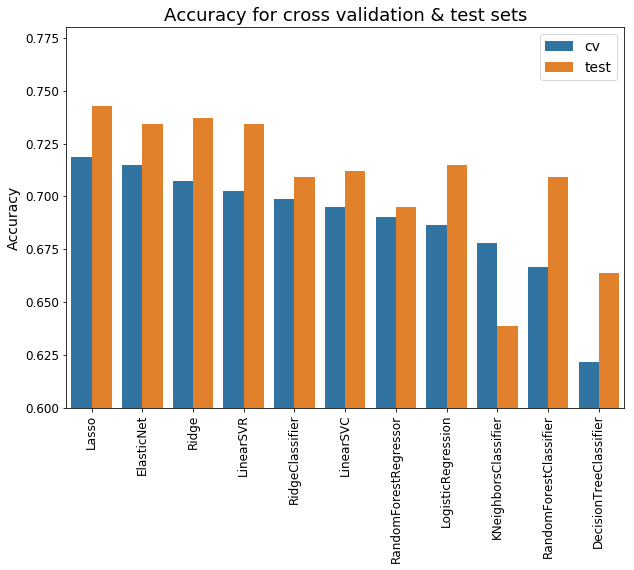

In [6]:
# Accuracy scores
acc_scores = classifier_scores.append(regressor_scores).sort_values(['score_type', 'accuracy'], ascending=[True, False])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='accuracy', hue='score_type', data=acc_scores)
plt.ylim(ymin=0.60)
plt.title('Accuracy for cross validation & test sets', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Linear regressors perform a little better than linear classifiers

Having played around with this over many different runs, classifiers sometimes get slightly better accuracy, but regressors tend to be better on cross validation, only sometimes over-fitting the data and getting worse performance than classifiers on the test set. Also, regressors are more convenient to use for predictions, because I'll need to predict score differentials for the tipping competition. So, I'll approach this as a regression problem and thus narrow down my tuning options by limiting the available algorithms. It's not super important, but the squiggle.com.au tipping competition requires models to predict margins on all matches, so if I want to compare myself to the best, I'll have to do the same.

## Use match rows or team-match rows?

In [7]:
# Reshape model_df to split each match into 2 rows: 1 per participating team

team_df = team_betting_model_df(model_df)
team_df

team         oppo_team  score  \
team             year round_number                                              
Adelaide         2010 1                     Adelaide         Fremantle   62.0   
                      2                     Adelaide            Sydney   75.0   
                      3                     Adelaide         Melbourne   41.0   
                      4                     Adelaide           Carlton   55.0   
                      5                     Adelaide  Western Bulldogs   72.0   
                      6                     Adelaide     Port Adelaide   74.0   
                      7                     Adelaide          Richmond  104.0   
                      8                     Adelaide   North Melbourne   75.0   
                      9                     Adelaide          Brisbane   93.0   
                      10                    Adelaide          St Kilda   76.0   
                      11                    Adelaide         Fremantle  105.0   
                      12                    Adelaide          Hawthorn   77.0   
                      13                    Adelaide         Melbourne  117.0   
                      14                    Adelaide          Essendon  124.0   
                      15                    Adelaide        West Coast  117.0   
                      16                    Adelaide           Geelong   74.0   
                      17                    Adelaide     Port Adelaide   69.0   
                      18                    Adelaide          Richmond   80.0   
                      19                    Adelaide  Western Bulldogs   53.0   
                      20                    Adelaide          Brisbane  104.0   
                      21                    Adelaide       Collingwood   51.0   
                      22                    Adelaide          St Kilda   65.0   
                 2011 1                     Adelaide          Hawthorn  105.0   
                      3                     Adelaide         Fremantle   54.0   
                      4                     Adelaide     Port Adelaide   66.0   
                      5                     Adelaide           Carlton   79.0   
                      6                     Adelaide          St Kilda   90.0   
                      7                     Adelaide         Melbourne   53.0   
                      8                     Adelaide        Gold Coast  130.0   
                      9                     Adelaide       Collingwood   92.0   
...                                              ...               ...    ...   
Western Bulldogs 2015 21            Western Bulldogs        West Coast   85.0   
                      22            Western Bulldogs   North Melbourne   96.0   
                      23            Western Bulldogs          Brisbane  122.0   
                      25            Western Bulldogs          Adelaide  102.0   
                 2016 1             Western Bulldogs         Fremantle  103.0   
                      2             Western Bulldogs          St Kilda   93.0   
                      3             Western Bulldogs          Hawthorn   90.0   
                      4             Western Bulldogs           Carlton   85.0   
                      5             Western Bulldogs          Brisbane  120.0   
                      6             Western Bulldogs   North Melbourne   45.0   
                      7             Western Bulldogs          Adelaide  123.0   
                      8             Western Bulldogs         Melbourne  114.0   
                      9             Western Bulldogs               GWS   73.0   
                      10            Western Bulldogs       Collingwood   74.0   
                      11            Western Bulldogs        West Coast   83.0   
                      12            Western Bulldogs     Port Adelaide  100.0   
                      13            Western Bulldogs           Geelong   43.0  

In [8]:
team_features = pd.get_dummies(team_df.drop(['score', 'oppo_score'], axis=1))
team_labels = pd.Series(team_df['score'] - team_df['oppo_score'], name='score_diff')
data = train_test_split(team_features, team_labels)
                        
estimator_scores = measure_estimators(regressors, data, model_type='regression')



Lasso
Mean CV accuracy: 0.7203329633740287
Test accuracy: 0.7288135593220338

Mean CV negative error score: 28.984501631080235
Test error score: 28.263680345174627


ElasticNet
Mean CV accuracy: 0.7203274139844618
Test accuracy: 0.7330508474576272

Mean CV negative error score: 29.153091390400686
Test error score: 28.40627973356191


Ridge
Mean CV accuracy: 0.7212674805771366
Test accuracy: 0.7330508474576272

Mean CV negative error score: 29.13315982592003
Test error score: 28.3609221435979


LinearSVR
Mean CV accuracy: 0.7184506104328523
Test accuracy: 0.7245762711864406

Mean CV negative error score: 29.224887180697653
Test error score: 28.451823969061227


RandomForestRegressor
Mean CV accuracy: 0.6798412874583796
Test accuracy: 0.6949152542372882

Mean CV negative error score: 32.05720188679245
Test error score: 31.519774011299436


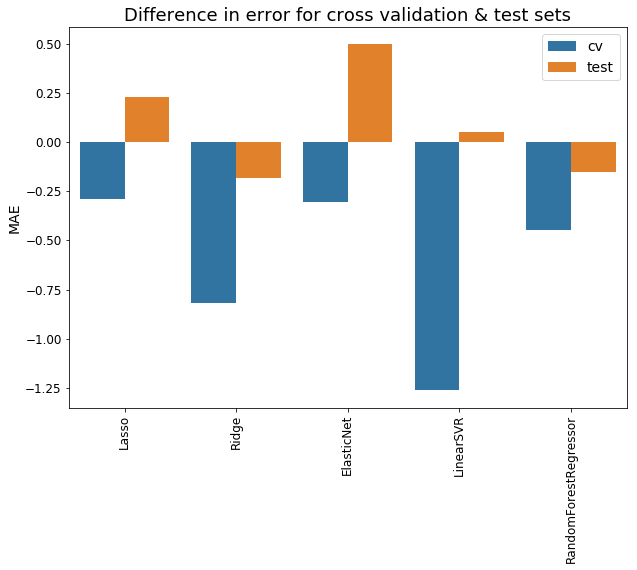

In [9]:
# Accuracy scores

comparison = (estimator_scores.assign(error_diff=estimator_scores['error'] - regressor_scores['error'])
                              .sort_values(['score_type', 'error'], ascending=[True, True]))

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='error_diff', hue='score_type', data=comparison)
plt.title('Difference in error for cross validation & test sets', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Organising data by team-matches has slightly positive impact on performance

It's close enough that it can vary by data split, but since this organisation is necessary for cumulative features, this is potentially more convenient, but it may require an extra step when measuring performance to make sure two opponents aren't predicted to win, resulting in 50% accuracy rather than 0% or 100% per match.